<a href="https://colab.research.google.com/github/ZhNurlayeva/amd_link_analysis/blob/main/amd_link_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup

### 0.1 Install required packages

Install external libraries for title normalisation, MinHash/LSH, and sentence-based similarity.

In [ ]:
!pip install kaggle datasketch -q
!pip install sentence-transformers jellyfish python-Levenshtein faiss-cpu -q


### 0.2 Imports

Core scientific stack, graph tools, similarity functions, and MinHash/LSH.

In [ ]:
# Core Python and scientific stack
import os
import time
import re
import gc
import unicodedata
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

# String similarity and semantic models for title normalisation
import jellyfish
import Levenshtein
from sentence_transformers import SentenceTransformer

# MinHash and LSH for scalable similarity search
from datasketch import MinHash, MinHashLSH


### 0.3 Kaggle API configuration

Upload kaggle.json and configure the Kaggle API for programmatic dataset download.

In [ ]:
#from google.colab import files
#from kaggle.api.kaggle_api_extended import KaggleApi

#uploaded = files.upload()  # upload kaggle.json

#!mkdir -p /root/.config/kaggle
#!cp kaggle.json /root/.config/kaggle/kaggle.json
#!chmod 600 /root/.config/kaggle/kaggle.json

#api = KaggleApi()
#api.authenticate()
import os

KAGGLE_DIR = "/root/.config/kaggle"
KAGGLE_PATH = f"{KAGGLE_DIR}/kaggle.json"

# 1) Ensure kaggle.json exists (upload only if missing)
if not os.path.exists(KAGGLE_PATH):
    from google.colab import files
    uploaded = files.upload()  # upload kaggle.json

    os.makedirs(KAGGLE_DIR, exist_ok=True)
    !cp kaggle.json /root/.config/kaggle/kaggle.json
    !chmod 600 /root/.config/kaggle/kaggle.json

# 2) Now import and authenticate
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

print("Kaggle API authenticated.")



### 1. Data acquisition

Download the Amazon Books Reviews dataset from Kaggle and load the two source files:

* the main ratings table containing user–book interactions, and
* the metadata table containing book-level attributes.  

These raw tables form the starting point for all later cleaning, filtering, and graph construction.



In [ ]:
DATASET_NAME = "mohamedbakhet/amazon-books-reviews"

api.dataset_download_files(
    dataset=DATASET_NAME,
    path=".",
    unzip=True,
    quiet=False
)

RATINGS_PATH = "Books_rating.csv"
BOOKS_META_PATH = "books_data.csv"

df_raw = pd.read_csv(RATINGS_PATH)
df_meta = pd.read_csv(BOOKS_META_PATH)

print("Ratings shape:", df_raw.shape)
print("Metadata shape:", df_meta.shape)
print("Ratings columns:", list(df_raw.columns))
print("Metadata columns:", list(df_meta.columns))


The ratings table contains 3M user–book interactions with review timestamps and scores, while the metadata file provides supplementary information such as categories, authors, and publication data. Both tables will be merged later, but at this stage the goal is to confirm their size and schema before preprocessing.


### 2. Basic dataset inspection

Inspect the size, completeness, and sparsity of the raw ratings table before applying any cleaning steps. These diagnostics highlight missing identifiers and the long-tail distribution of user activity and book popularity, which will justify filtering thresholds used in later preprocessing.


In [ ]:
print("# Basic dataset profile")

total_reviews = len(df_raw)
n_users       = df_raw["User_id"].nunique()
n_ids         = df_raw["Id"].nunique()
n_titles_raw  = df_raw["Title"].nunique()

print(f"Total reviews          : {total_reviews:,}")
print(f"Distinct book IDs      : {n_ids:,}")
print(f"Distinct raw titles    : {n_titles_raw:,}")
print(f"Distinct users         : {n_users:,}")

print("\n# Missing values in key fields")
print(df_raw[["Id", "Title", "User_id", "review/score"]].isna().sum())

print("\n# Sparsity indicators")

# Reviews per raw title
book_review_counts = df_raw["Title"].value_counts()
print(
    "Reviews per title   – "
    f"median={book_review_counts.median():.1f}, "
    f"mean={book_review_counts.mean():.1f}, "
    f"max={book_review_counts.max():,}"
)

# Reviews per user (excluding missing user ids)
valid_users_df = df_raw.dropna(subset=["User_id"])
user_review_counts = valid_users_df["User_id"].value_counts()
print(
    "Reviews per user    – "
    f"median={user_review_counts.median():.1f}, "
    f"mean={user_review_counts.mean():.1f}, "
    f"max={user_review_counts.max():,}"
)

# Share of very low-activity users and titles
users_1_or_2  = (user_review_counts <= 2).mean() * 100
books_less_10 = (book_review_counts < 10).mean() * 100
print(f"Users with 1–2 reviews : {users_1_or_2:4.1f}%")
print(f"Titles with <10 reviews: {books_less_10:4.1f}%")


The dataset is extremely sparse: most users have only one or two reviews, and most titles receive fewer than ten reviews. Such long-tail behaviour indicates that a large portion of the data cannot support meaningful overlap signals for graph construction. These statistics motivate the row-reduction step that follows, where both low-activity users and low-review titles are filtered out to obtain a denser and more reliable interaction core.


### 2.1 Merge category metadata

Attach category labels from the metadata table to the raw ratings so that each title carries a genre/category attribute when available. These labels are not used for graph construction but will support downstream interpretation of central books and community structure.




In [ ]:
df_meta_small = df_meta[["Title", "categories"]].drop_duplicates()

df_raw = df_raw.merge(
    df_meta_small,
    on="Title",
    how="left"
)

print("Metadata merged. Distinct categories:", df_raw["categories"].nunique(dropna=False))


The merge succeeds for most titles, though the category field remains highly heterogeneous with many distinct labels. These categories will not affect preprocessing but will be aggregated later to characterise the genres of structurally central books.


### 3. Cleaning of interaction data

Construct a clean interaction table containing only the fields needed for graph construction. Missing identifiers are removed, category labels are normalised, and repeated (user, book) interactions are dropped. This step ensures that downstream row-reduction and title normalisation operate on a consistent and deduplicated dataset.


In [ ]:
# Keep only fields used later in the pipeline
df_clean = df_raw[["Id", "Title", "User_id", "review/score", "review/time", "categories"]].copy()

# Replace missing categories with a neutral label
df_clean["categories"] = df_clean["categories"].fillna("Unknown")

# Remove rows with missing key identifiers
before = len(df_clean)
df_clean = df_clean.dropna(subset=["Id", "Title", "User_id"])
after = len(df_clean)
print(f"Rows removed due to missing Id/Title/User_id: {before - after:,}")
print(f"Remaining rows after NA cleaning             : {after:,}")

# Remove duplicate interactions: same user reviewing the same book multiple times
before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=["User_id", "Id"], keep="first")
after = len(df_clean)
print(f"Duplicate (User_id, Id) pairs removed        : {before - after:,}")
print(f"Unique (User_id, Id) interactions            : {after:,}")

# Updated uniqueness counts
print(f"Distinct users after cleaning                : {df_clean['User_id'].nunique():,}")
print(f"Distinct book IDs after cleaning             : {df_clean['Id'].nunique():,}")
print(f"Distinct raw titles after cleaning           : {df_clean['Title'].nunique():,}")
print(f"Distinct categories (incl. 'Unknown')        : {df_clean['categories'].nunique():,}")


The removal of missing identifiers and duplicate interactions reduces the dataset to a clean set of unique user–book pairs. The number of titles and users remains high, but the interactions become more reliable for later analysis of reviewer overlap. Normalising missing categories ensures that all books carry a valid label for downstream genre-based interpretation of centrality and communities.


###4. Row reduction (core extraction)

This step filters the cleaned interaction table `df_clean` down to an active core `df_core_raw`.
Based on the distributions `book_counts_all` and `user_counts_all` (showing that ~80% of titles have fewer than 10 reviews and most users write only 1–2 reviews), it keeps only titles with at least `MIN_REVIEWS_PER_BOOK = 20` reviews and users with at least `MIN_REVIEWS_PER_USER = 3` reviews. This ensures that, when `df_core_raw` is later converted into reviewer sets (`book_users`) and edges between books are defined by ≥2 shared reviewers, the overlap signal is not dominated by almost-isolated titles or one-off users.



In [ ]:
print("Row reduction on cleaned interactions")

# Reviews per (raw) title and per user, after basic cleaning
book_counts_all = df_clean["Title"].value_counts()
user_counts_all = df_clean["User_id"].value_counts()

print("Books – reviews per (raw) title")
print(book_counts_all.describe(percentiles=[0.5, 0.75, 0.9, 0.99]))

print("\nUsers – reviews per user")
print(user_counts_all.describe(percentiles=[0.5, 0.75, 0.9, 0.99]))

# Thresholds for the interaction core
MIN_REVIEWS_PER_BOOK = 20    # keep titles with at least 20 reviews
MIN_REVIEWS_PER_USER = 3     # keep users who reviewed at least 3 books

print(
    f"\nFiltering titles with ≥ {MIN_REVIEWS_PER_BOOK} reviews "
    f"and users with ≥ {MIN_REVIEWS_PER_USER} reviews..."
)

# Select popular titles and active users
popular_titles = book_counts_all[book_counts_all >= MIN_REVIEWS_PER_BOOK].index
active_users   = user_counts_all[user_counts_all >= MIN_REVIEWS_PER_USER].index

# Core interaction table (still with raw titles)
df_core_raw = df_clean[
    df_clean["Title"].isin(popular_titles)
    & df_clean["User_id"].isin(active_users)
].copy()

print(f"Rows after core filtering : {len(df_core_raw):,}")
print(f"Distinct raw titles       : {df_core_raw['Title'].nunique():,}")
print(f"Distinct users            : {df_core_raw['User_id'].nunique():,}")


The summary confirms that the raw interaction space is highly skewed: many titles and users sit in the extreme long tail, while a smaller subset carries most of the interaction mass.  
After filtering, `df_core_raw` still contains over one million interactions, but now restricted to ~18k raw titles and ~157k active users, each with enough activity to participate in meaningful co-review overlaps.  
This focused core strikes a balance between coverage and reliability and is the actual dataset on which title normalisation, reviewer-set construction, and the PageRank-based ranking will operate.



### 5. Canonical title normalisation

#### 5.1 Rule-based and semantic normalisation

The raw interaction core `df_core_raw` still contains many textual variants of the same book
(e.g. different editions, formats, or small punctuation differences in the title).  
If each variant were treated as a separate node, the co-review graph would fragment the same work across multiple titles,
distorting degrees, reviewer overlaps, and ultimately PageRank.

The `TitleCanonicalizer` class defines a normalisation pipeline that:
- performs rule-based cleaning of the raw `Title` strings (removing format markers, brackets, punctuation),  
- extracts a simplified “core” title,  
- uses string similarity (Jaro–Winkler and Levenshtein) to cluster close variants, and  
- refines the mapping on the most popular titles with a sentence-transformer model, merging semantically similar variants.

The output is a dictionary `title_map_` that maps each raw `Title` in `df_core_raw` to a canonical representative, ensuring that each underlying work will correspond to a single node in the co-review graph.


In [ ]:
class TitleCanonicalizer:

    def __init__(self, use_semantic=True, max_semantic_titles=5000):
        self.use_semantic = use_semantic
        self.max_semantic_titles = max_semantic_titles
        self._st_model = None
        self.title_map_ = {}


    # Basic text cleaning
    def _clean_basic(self, title: str) -> str:
        if pd.isna(title):
            return ""

        t = str(title).lower().strip()
        t = re.sub(r"\[.*?\]", " ", t)
        t = re.sub(r"\(.*?\)", " ", t)

        noise_patterns = [
            r"\bpaperback\b",
            r"\bhardcover\b",
            r"\bkindle\b",
            r"\baudio\s*book\b",
            r"\baudiobook\b",
            r"\bcd\b",
            r"\bdvd\b",
            r"\bedition\b",
            r"\bvolume\b",
            r"\bvol\.\b",
            r"\bclassics?\b",
            r"\billustrated\b",
        ]
        for pat in noise_patterns:
            t = re.sub(pat, " ", t)

        t = re.sub(r"[^a-z0-9\s]", " ", t)
        return " ".join(t.split())


    # Extract core title
    def _core_title(self, title: str) -> str:
        if pd.isna(title):
            return ""

        t = str(title).lower()

        m = re.match(r"^([^:;]+)", t)
        if m:
            t = m.group(1)

        t = re.sub(r"\bby\s+[a-z\s\.]+$", " ", t)
        t = re.sub(r"\([^)]*\)", " ", t)
        t = re.sub(r"[^a-z0-9\s]", " ", t)
        return " ".join(t.split())

    # String similarity
    def _string_similarity(self, t1: str, t2: str) -> float:
        if not t1 or not t2:
            return 0.0

        b1 = self._clean_basic(t1)
        b2 = self._clean_basic(t2)
        c1 = self._core_title(t1)
        c2 = self._core_title(t2)

        sims = []
        if b1 and b2:
            sims.append(jellyfish.jaro_winkler_similarity(b1, b2))
            sims.append(Levenshtein.ratio(b1, b2))
        if c1 and c2:
            sims.append(jellyfish.jaro_winkler_similarity(c1, c2))
            sims.append(Levenshtein.ratio(c1, c2))

        return max(sims) if sims else 0.0


    # Pick canonical title in a cluster
    def _pick_canonical(self, variants, df):
        scores = {}
        for t in variants:
            score = 0
            score += df[df["Title"] == t].shape[0] * 10   # popularity
            score -= len(t) * 0.1                         # shorter is preferred
            for marker in ["audiobook", "kindle", "paperback", "hardcover", "edition"]:
                if marker in t.lower():
                    score -= 50
            score -= len(re.findall(r"[^\w\s]", t)) * 5   # punctuation penalty
            scores[t] = score

        return max(scores.items(), key=lambda x: x[1])[0]


    # Popularity-aware semantic refinement
    def _semantic_refinement(self, canonical_titles, df, sim_threshold=0.85):

        if not self.use_semantic or len(canonical_titles) <= 1:
            return {}

        title_counts = df["Title"].value_counts()

        popular_order = (
            pd.Series(list(canonical_titles), name="Title")
            .drop_duplicates()
            .to_frame()
            .join(title_counts.rename("count"), on="Title")
            .fillna(0)
            .sort_values("count", ascending=False)
        )

        popular_titles = popular_order["Title"].tolist()
        titles_sub = popular_titles[: self.max_semantic_titles]

        if len(popular_titles) > self.max_semantic_titles:
            print(f"  Semantic refinement on top {self.max_semantic_titles} most-reviewed titles")
        else:
            print(f"  Semantic refinement on all {len(popular_titles)} canonical titles")

        if len(titles_sub) <= 1:
            return {}

        print("  Encoding titles with sentence-transformers...")
        if self._st_model is None:
            self._st_model = SentenceTransformer("all-MiniLM-L6-v2")

        emb = self._st_model.encode(
            titles_sub,
            show_progress_bar=False,
            normalize_embeddings=True
        )

        sim_mat = np.dot(emb, emb.T)

        used = set()
        clusters = []
        for i in range(len(titles_sub)):
            if i in used:
                continue
            close_idx = np.where(sim_mat[i] >= sim_threshold)[0]
            group = [titles_sub[j] for j in close_idx]
            if len(group) > 1:
                clusters.append(group)
            used.update(close_idx)

        semantic_map = {}
        for group in clusters:
            canon = self._pick_canonical(group, df)
            for t in group:
                semantic_map[t] = canon

        return semantic_map


    # Main method
    def fit(self, df, sim_threshold=0.85):

        print("Advanced title normalization")
        all_titles = df["Title"].dropna().unique()
        print(f"Raw unique titles: {len(all_titles):,}")

        grouped = defaultdict(list)
        for t in all_titles:
            key = self._clean_basic(t)
            if key:
                grouped[key].append(t)

        base_map = {}
        canonical_list = []

        for key, group in grouped.items():
            if len(group) == 1:
                base_map[group[0]] = group[0]
                canonical_list.append(group[0])
            else:
                canon = self._pick_canonical(group, df)
                for t in group:
                    base_map[t] = canon
                canonical_list.append(canon)

        extra_map = self._semantic_refinement(canonical_list, df, sim_threshold=sim_threshold)

        final_map = {}
        for orig, canon in base_map.items():
            final_map[orig] = extra_map.get(canon, canon)

        self.title_map_ = final_map
        merged = sum(1 for k, v in final_map.items() if k != v)
        print(f"Titles merged into canonical forms: {merged:,}")

        return self.title_map_


### 5.2 Apply canonical mapping to the interaction core

The normalisation is applied only to the reduced interaction core `df_core_raw`  
(≈18k raw titles after row reduction) to keep runtime manageable while still covering all high-activity books.  
The fitted `TitleCanonicalizer` produces `title_map_core`, which is used to build:

- a canonical interaction table `df_core`, with both `Title_original` and `Title_canon`, and  
- an aggregated category label `category_final` for each canonical title, obtained by majority vote over `categories`.

After this step, each canonical title in `df_core` will be used as a unique node when constructing reviewer sets and the co-review graph.


In [ ]:
normalizer = TitleCanonicalizer(use_semantic=True, max_semantic_titles=5000)

start = time.time()
title_map_core = normalizer.fit(df_core_raw, sim_threshold=0.85)
end = time.time()
print(f"\nCore deduplication (with semantic refinement) completed in {end - start:.1f} seconds")

# Construct canonical interaction table
df_core = df_core_raw.copy()
df_core["Title_original"] = df_core["Title"]
df_core["Title_canon"] = df_core["Title"].map(lambda t: title_map_core.get(t, t))

# Aggregate categories at canonical-title level (majority label)
cat_counts_core = (
    df_core.groupby(["Title_canon", "categories"])
    .size()
    .reset_index(name="n")
)

top_category_core = (
    cat_counts_core.sort_values(["Title_canon", "n"], ascending=[True, False])
    .drop_duplicates(subset=["Title_canon"])
    .set_index("Title_canon")["categories"]
    .to_dict()
)

df_core["category_final"] = df_core["Title_canon"].map(top_category_core)

print("\nCore deduplication summary")
print(f"Unique raw titles in core       : {df_core_raw['Title'].nunique():,}")
print(f"Unique canonical titles in core : {df_core['Title_canon'].nunique():,}")

# Remove duplicate (User_id, Title_canon) pairs created by merging
before = len(df_core)
df_core = df_core.drop_duplicates(subset=["User_id", "Title_canon"], keep="first")
after = len(df_core)
print(
    f"Final canonical core for link analysis: {after:,} reviews "
    f"(removed {before - after:,} duplicate user–title pairs)"
)


The normalisation step starts from 18,421 raw titles in `df_core_raw` and merges 2,239 of them into canonical forms,
resulting in 16,182 distinct `Title_canon` entries.  
This shows that a non-trivial fraction of the interaction core was affected by edition/format variants or minor textual differences.

After applying `title_map_core` and dropping duplicate `(User_id, Title_canon)` pairs, the final canonical core contains 596,700 reviews.
Each canonical title now aggregates all reviews that previously belonged to its fragmented variants, and each `(user, book)` interaction appears at most once.

This cleaned table `df_core` is the basis for:
- building reviewer sets `book_users[Title_canon]`,  
- defining edges between books when at least two users reviewed both titles, and  
- interpreting central books by their majority genre label `category_final`.

In practice, this step prevents the PageRank-based ranking from artificially splitting influential works across multiple nodes, and stabilises both degree and overlap statistics in the co-review network.


### 6. Duplicate consolidation

### 6.1 Detection of suspicious duplicate canonical titles

Even after the main `TitleCanonicalizer` step, some works may still appear under multiple very similar `Title_canon` strings
(e.g. colon vs bracket variants, slightly different subtitles).  
To detect these residual cases, a simplified normalised form `core_simple` is computed by lowercasing `Title_canon` and stripping all non-alphanumeric characters.

Grouping `df_core` by `core_simple` and counting distinct `Title_canon` reveals clusters where several canonical titles collapse to the same simplified form.
These clusters are stored in `suspicious_dict` and represent high-confidence duplicate candidates that can be harmonised without affecting genuinely distinct books.



In [ ]:
def simple_core(t):
    t = t.lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    return " ".join(t.split())

df_core["core_simple"] = df_core["Title_canon"].map(simple_core)

group_sizes = df_core.groupby("core_simple")["Title_canon"].nunique()
suspicious = group_sizes[group_sizes > 1]

suspicious_dict = {}
for core in suspicious.index:
    titles = sorted(df_core[df_core["core_simple"] == core]["Title_canon"].unique())
    suspicious_dict[core] = titles

print("Suspicious groups detected:", len(suspicious_dict))


### 6.2 Harmonisation of suspicious duplicate groups

For each group in `suspicious_dict`, the titles differ only by minor formatting or punctuation and refer to the same underlying work.
To avoid creating multiple nodes for such variants, each group is collapsed to a single representative string, chosen as the shortest title in the group.

The mapping `harmonisation_map` is then applied to `df_core["Title_canon"]`, so all occurrences of that work share the same canonical label
before building reviewer sets and edges.


In [ ]:
harmonisation_map = {}

for core, titles in suspicious_dict.items():
    representative = min(titles, key=len)
    for t in titles:
        harmonisation_map[t] = representative

df_core["Title_canon"] = df_core["Title_canon"].replace(harmonisation_map)


### 6.3 Deterministic consolidation of high-impact duplicate works

Automatic rules and `core_simple` harmonisation still leave a few prominent works split across edition-specific or annotated variants
(e.g. boxed sets, study guides, anniversary editions).  
Inspecting the most reviewed titles and the suspicious groups highlighted a small set of recurring cases
such as *The Hobbit*, *The Lord of the Rings* boxed sets, *1984*, *Animal Farm*, *Jane Eyre*, and similar classics.

To avoid over-complicating the normaliser, these high-impact cases are encoded explicitly in a small dictionary `manual_title_map`
that maps edition-specific `Title_canon` labels to a single, stable representative for each work.
This manual consolidation is applied only to a handful of very visible books, ensuring that the graph does not artificially fragment their degree and overlap structure.


In [ ]:
manual_title_map = {
    # Hobbit family
    "The Hobbit There and Back Again": "The Hobbit",
    "The Hobbitt, or there and back again; illustrated by the author.": "The Hobbit",

    # Lord of the Rings family
    "The Lord of the Rings - Boxed Set":
        "The Lord of the Rings Trilogy (The Fellowship of the Ring, The Two Towers, The Return of the King, I, II, III)",
    "The Lord Of The Rings THREE VOLUME BOXED SET (The Fellowship Of The Ring, The Return of The King, The Two towers)":
        "The Lord of the Rings Trilogy (The Fellowship of the Ring, The Two Towers, The Return of the King, I, II, III)",
    "The Lord of the Rings (3 Volume Set)":
        "The Lord of the Rings Trilogy (The Fellowship of the Ring, The Two Towers, The Return of the King, I, II, III)",
    "The Lord of the Rings Trilogy: Three Volumes in Slipcase":
        "The Lord of the Rings Trilogy (The Fellowship of the Ring, The Two Towers, The Return of the King, I, II, III)",

    # Pride and Prejudice
    "Pride & Prejudice (Penguin Classics)": "Pride and Prejudice",

    # To Kill a Mockingbird
    "Harper Lee's To Kill a Mockingbird (Barron's Book Notes)": "To kill a mockingbird",

    # 1984 variants
    "Nineteen Eighty-four": "1984",
    "George Orwell 1984": "1984",

    # Animal Farm variants
    "Animal Farm 50TH Anniversary Edition": "Animal Farm",
    "ANIMAL FARM - A Fairy Story (Time Reading Program Special Edition)": "Animal Farm",

    # Christmas Carol variants
    "Christmas Carol (Ladybird Classics)": "A Christmas Carol (Classic Fiction)",

    # Jane Eyre variants
    "Jane Eyre: Complete and Unabridged (Puffin Classics)": "Jane Eyre",

    # The Red Tent
    "The Red Tent (Bestselling Backlist)": "The Red Tent",
    "Red Tent": "The Red Tent",

    # In the Heart of the Sea
    "In the Heart of the Sea: The Tragedy of the Whaleship Essex": "In the Heart of the Sea",

    # The Lion, the Witch and the Wardrobe
    "The Lion, the Witch and the Wardrobe Movie Tie-in Edition":
    "The Lion, the Witch and the Wardrobe",
    "The Lion, the Witch and the Wardrobe Movie Tie-in Edition (The Chronicles of Narnia)":
    "The Lion, the Witch and the Wardrobe",
    "The Lion, the Witch and the Wardrobe Movie Tie-in Edition (T...whatever full string you see...)":
    "The Lion, the Witch and the Wardrobe",


    # The Great Gatsby
    "Great Gatsby (Everyman)": "The Great Gatsby",

    # Suspicious small groups found earlier
    "Art Fundamentals (Theory and Practice)": "Art Fundamentals: Theory and Practice",
    "Database Processing (Fundamentals, Design, and Implementation)":
        "Database Processing: Fundamentals, Design and Implementation",
    "Trophy Hunt (A JOE PICKETT NOVEL)": "Trophy Hunt: A Joe Pickett Novel",
    "Warrior's Song (Medieval Song Quartet #4)": "Warrior's Song: Medieval Song Quartet #4",
}

df_core["Title_canon"] = df_core["Title_canon"].replace(manual_title_map)


### 6.4 Recompute categories and clean duplicate (user, title) pairspairs

After all automatic and manual merges, the category and interaction counts must be recomputed at the level of the final `Title_canon` labels.
For each canonical title, the majority category over the original `categories` is stored in `category_final`,
so that genres can later be used to interpret central books and communities.

Merging titles can also create duplicate `(User_id, Title_canon)` pairs when a user reviewed several variants of the same work.
These duplicates are dropped to obtain the final canonical interaction table that will feed reviewer-set construction and graph building.


In [ ]:
cat_counts_core = (
    df_core.groupby(["Title_canon", "categories"])
    .size()
    .reset_index(name="n")
)

top_category_core = (
    cat_counts_core.sort_values(["Title_canon", "n"], ascending=[True, False])
    .drop_duplicates(subset=["Title_canon"])
    .set_index("Title_canon")["categories"]
    .to_dict()
)

df_core["category_final"] = df_core["Title_canon"].map(top_category_core)

# Remove duplicates produced by merging
before = len(df_core)
df_core = df_core.drop_duplicates(subset=["User_id", "Title_canon"], keep="first")
after = len(df_core)

print("Canonical titles after all merges:", df_core["Title_canon"].nunique())
print("Final canonical interactions:", after)


After automatic refinement, suspicious-group harmonisation, and targeted manual consolidation,
the number of canonical titles stabilises at 16,160 and the final canonical core contains 568,954 user–book interactions.

This means that a relatively small number of high-impact works were affected by manual decisions, while the vast majority of titles are handled purely by the automatic pipeline.
At this point, each `Title_canon` represents a stable book-level node with:

- a unique label used in reviewer sets and in the co-review graph,  
- a majority-vote genre `category_final`, and  
- at most one interaction per `(User_id, Title_canon)` pair.

The resulting `df_core` is the definitive interaction table on which reviewer sets, MinHash/LSH candidate generation, edge construction, and PageRank-based ranking are built.


### 7. Reviewer sets and LSH-based edge construction

#### 7.1 Reviewer sets for canonical titles

At this stage, each row of `df_core` is a cleaned interaction between a user and a canonical book title.
To construct book–book links, the first step is to invert this table and build a mapping:

- `book_users[Title_canon] = set of user IDs that reviewed this book`.

These reviewer sets are the basic objects used to measure co-review overlap.
The summary statistics on `reviewers_per_book` show how many distinct users are attached to each canonical title,
which will later drive the strength and reliability of edges in the co-review graph.


In [ ]:
from collections import defaultdict

book_users = defaultdict(set)

for row in df_core.itertuples(index=False):
    book = row.Title_canon
    user = str(row.User_id)
    book_users[book].add(user)

n_books = len(book_users)
reviewers_per_book = pd.Series(
    {b: len(u) for b, u in book_users.items()},
    name="n_reviewers"
)

print(f"Distinct canonical titles in reviewer sets: {n_books:,}")
print("\nReviewers per canonical title:")
print(
    reviewers_per_book.describe(
        percentiles=[0.50, 0.75, 0.90, 0.99]
    )
)

assert reviewers_per_book.min() >= 1, "Found a title with zero reviewers."


#### 7.2 MinHash signatures and LSH index

Computing exact reviewer-set overlaps for all book pairs would be quadratic in the number of titles and infeasible on this dataset.
To obtain a scalable approximation, each `book_users[title]` set is compressed into a MinHash signature of length `NUM_PERM`.

These signatures are indexed in a `MinHashLSH` structure with a Jaccard threshold `LSH_THRESHOLD`.
For each title, the LSH index returns only a small set of candidate neighbours with potentially non-negligible Jaccard similarity,
so that exact overlaps are computed only for promising pairs instead of for all possible combinations.


In [ ]:
from datasketch import MinHash, MinHashLSH

NUM_PERM = 128             # number of hash permutations
LSH_THRESHOLD = 0.1        # Jaccard threshold for candidate generation
MIN_COMMON_REVIEWERS = 2   # minimum shared reviewers to keep an edge (project requirement)

def build_minhash(user_set, num_perm=NUM_PERM):
    """Create a MinHash object from a set of user IDs."""
    m = MinHash(num_perm=num_perm)
    for u in user_set:
        m.update(u.encode("utf-8"))
    return m

print("Building MinHash signatures for canonical titles...")

book_ids = list(book_users.keys())
minhashes = {b: build_minhash(book_users[b]) for b in book_ids}

print(f"MinHashes created for {len(minhashes):,} canonical titles.")

print("Indexing MinHashes in LSH...")
lsh = MinHashLSH(threshold=LSH_THRESHOLD, num_perm=NUM_PERM)

for b in book_ids:
    lsh.insert(b, minhashes[b])

print("LSH indexing completed.")


#### 7.3 Candidate pairs and exact intersection edge construction

Using the LSH index, each title is matched only against a reduced set of candidate neighbours.
For each candidate pair `(b, c)`, the code:

1. Enforces a fixed ordering and tracks `seen_pairs` to avoid duplicates,  
2. Computes the exact intersection size `|book_users[b] ∩ book_users[c]|`,  
3. Keeps an undirected edge `(b, c, w)` only if `w ≥ MIN_COMMON_REVIEWERS`.

Setting `MIN_COMMON_REVIEWERS = 2` enforces the Project 3 requirement:
two books are linked only if **at least two distinct users** reviewed both.
The resulting list `edges` is a sparse but informative representation of co-review similarity,
with weights equal to the number of shared reviewers.


In [ ]:
edges = []          # list of (book1, book2, common_reviewers)
seen_pairs = set()  # to avoid duplicates

print("Generating candidate edges via LSH and checking exact overlaps...")

for i, b in enumerate(book_ids):
    candidates = lsh.query(minhashes[b])

    for c in candidates:
        if c == b:
            continue

        pair = tuple(sorted((b, c)))
        if pair in seen_pairs:
            continue
        seen_pairs.add(pair)

        users_b = book_users[pair[0]]
        users_c = book_users[pair[1]]
        common = len(users_b & users_c)

        if common >= MIN_COMMON_REVIEWERS:
            edges.append((pair[0], pair[1], common))

    if (i + 1) % 500 == 0:
        print(f"  processed {i+1:,} / {len(book_ids):,} canonical titles...")

print(f"\nTotal edges with ≥ {MIN_COMMON_REVIEWERS} shared reviewers: {len(edges):,}")

common_counts = pd.Series([w for _, _, w in edges], name="n_common_reviewers")
print("\nDistribution of common reviewers per edge:")
print(common_counts.describe(percentiles=[0.5, 0.75, 0.9, 0.99]))


The reviewer-set inversion and LSH-based candidate generation produce:

- 16,160 canonical titles with at least one reviewer, and  
- 40,813 undirected edges where two books share at least two distinct users.

The distribution of `n_common_reviewers` is strongly skewed:  
most edges correspond to pairs with only 2–4 shared users, while a small minority reach dozens or even hundreds of common reviewers.

This structure matches the intuition behind co-review networks:
most book pairs are weakly related, but a few pairs are tied together by large, overlapping audiences.
The `edges` list obtained here is the final input for constructing the weighted book–book graph in the next section, where each edge weight encodes the strength of this shared readership.


### 8. Co-Review Graph Construction and Network Summary

#### 8.1 Graph construction

The reviewer-overlap edges computed in Section 7 are now assembled into an undirected weighted graph `G`.
Each canonical title becomes a node, annotated with its total number of reviewers (`n_reviewers`),
and an edge `(b1, b2, w)` is added whenever two books share at least `w ≥ 2` distinct reviewers.

The edge weights encode the strength of co-review similarity and form the input structure for all subsequent analyses:
connected components, network sparsity, and PageRank-based ranking.


In [ ]:
G = nx.Graph()

# Add nodes with attribute: number of reviewers
for b, users in book_users.items():
    G.add_node(b, n_reviewers=len(users))

# Add weighted edges (shared reviewers)
for b1, b2, w in edges:
    G.add_edge(b1, b2, weight=w)

print("Graph construction complete.")
print(f"Number of nodes (canonical titles): {G.number_of_nodes():,}")
print(f"Number of edges                   : {G.number_of_edges():,}")


#### 8.2 Network summary

Basic structural statistics characterise the co-review graph before focusing on the largest connected component.

- **Node/edge counts** show the overall scale.
- **Degree distribution** indicates how many other books each title is linked to.
- **Network density** quantifies sparsity (expected to be extremely low).
- **Connected components** reveal whether the graph forms one large audience-sharing ecosystem
  or many isolated clusters corresponding to niche genres or rarely reviewed works.

The size and coverage of the largest connected component (LCC) determine the subset of titles on which PageRank can be computed meaningfully.


In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Total books (nodes) : {num_nodes:,}")
print(f"Total edges         : {num_edges:,}")

# Degree statistics
degrees = np.array([deg for _, deg in G.degree()])
if len(degrees) > 0:
    print("\nDegree statistics:")
    print(f"  mean degree   : {degrees.mean():.2f}")
    print(f"  median degree : {np.median(degrees):.2f}")
    print(f"  min degree    : {degrees.min():.0f}")
    print(f"  max degree    : {degrees.max():.0f}")
else:
    print("\nGraph has no edges.")

# Network density
density = nx.density(G)
print(f"\nNetwork density: {density:.6f}")

# Connected components
components = list(nx.connected_components(G))
num_components = len(components)
largest_component = max(components, key=len) if components else set()

print(f"\nConnected components       : {num_components:,}")
print(f"Largest component size     : {len(largest_component):,}")
if num_nodes > 0:
    frac_lcc = len(largest_component) / num_nodes
    print(f"Fraction of nodes in LCC   : {frac_lcc:.2%}")


#### 8.3 Degree & edge-weight distributions


To inspect the structural shape of the graph, the degree distribution and edge-weight distribution
are plotted on a logarithmic scale.

- The **degree distribution** indicates how many other books each title is connected to
  through at least two shared reviewers.
- The **edge-weight distribution** describes how strongly linked these pairs are,
  based on the number of common reviewers.

Log-scaling highlights long-tail behaviour typical of real-world audience-overlap networks.


In [ ]:
if num_edges > 0:
    # Degree distribution
    plt.figure(figsize=(6,4))
    plt.hist(degrees, bins=40)
    plt.xlabel("Degree")
    plt.ylabel("Number of books")
    plt.title("Degree distribution (log scale)")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

    # Edge-weight distribution (number of shared reviewers)
    edge_weights = np.array([w for _, _, w in G.edges(data="weight")])

    plt.figure(figsize=(6,4))
    plt.hist(edge_weights, bins=40)
    plt.xlabel("Number of shared reviewers (edge weight)")
    plt.ylabel("Number of edges")
    plt.title("Edge weight distribution (log scale)")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()


The constructed co-review graph is extremely sparse, with density ≈ 0.000313,
yet it contains enough structure to support meaningful ranking.

**Degree distribution.**  
The majority of books have degree 0–5, indicating that most titles share audiences with only a few others.  
However, the long right tail (max degree = 104) reveals a small set of highly connected books—typically popular works reviewed by broad audiences.  
This heavy-tailed pattern is characteristic of real-world bipartite-projection networks.

**Edge-weight distribution.**  
Most links correspond to only 2–4 shared reviewers, but a small fraction of edges reach hundreds or even over a thousand shared users.  
These high-weight edges signify strong audience overlap and will play an important role in positioning hubs within a cluster.

**Connected components.**  
The graph fragments into **6,509 components**, but the largest connected component (LCC) contains **8,687 books**,  
covering **53.76% of all nodes**.  
Only nodes in the LCC participate in a globally connected recommendation structure,
and PageRank is meaningful only on this subgraph.

This component therefore becomes the focus of the ranking analysis in the next section.


### 9. PageRank on the Largest Connected Component

#### 9.1 Extract LCC and compute weighted PageRank

In Project 3 we must implement a ranking based on the **PageRank index**, where
> “books are linked together if they have been reviewed at least by two different users.”

In our graph `G`:
* each node is a **canonical title** (`Title_canon`);
* an undirected edge `(b1, b2)` exists if at least 2 users reviewed both books;
* the edge weight `weight` equals the **number of shared reviewers**.

Here we first extract the **largest connected component** (`G_lcc`) of `G`.  
PageRank is then computed on `G_lcc` using `networkx.pagerank`, with:
* `alpha = 0.85` = damping factor (probability that the random surfer **follows an edge**);
* `1 − alpha` = teleport probability (jump to a random node);
* `weight="weight"` = transitions biased by the **number of shared reviewers**.

This matches the PageRank definition: a stationary distribution of a random walk on the graph, here interpreted as a “random reader” who keeps moving between **co-reviewed books**.


In [ ]:
if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
    raise ValueError("Graph is empty — earlier preprocessing must be checked.")

# Identify the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

print(f"LCC size: {G_lcc.number_of_nodes():,} nodes, {G_lcc.number_of_edges():,} edges")

# Compute weighted PageRank
pagerank_scores = nx.pagerank(G_lcc, alpha=0.85, weight="weight")

# Store PageRank in node attributes
nx.set_node_attributes(G_lcc, pagerank_scores, "pagerank")


The LCC `G_lcc` contains **8,687 books** and **39,661 edges**, i.e. more than half of all titles in `G`.  
This is the main connected “reading universe” of the dataset; all subsequent rankings are computed on `G_lcc`, where PageRank can propagate influence along paths of co-reviewed books.


#### 9.2 Build PageRank DataFrame with structural descriptors

The dictionary `pagerank_scores` (keys = `Title_canon`, values = PageRank) is
converted into a dataframe `pr_df`.  
Three structural descriptors are then attached:

* `degree` — degree of the node in `G_lcc` (number of neighbour books).
* `n_reviewers` — size of the set `book_users[Title_canon]`
  (distinct users who reviewed the book in the canonical core).
* `n_reviews` — total number of canonical reviews of the book in `df_core`.

Finally, `pr_df` is sorted by `pagerank` in descending order.  
This table is the central object for later analyses comparing **PageRank** to simpler popularity proxies such as number of reviews or number of reviewers.


In [ ]:
pr_df = (
    pd.DataFrame.from_dict(pagerank_scores, orient="index", columns=["pagerank"])
    .rename_axis("Title_canon")
    .reset_index()
)

# Degree in the LCC
deg_dict = dict(G_lcc.degree())
pr_df["degree"] = pr_df["Title_canon"].map(deg_dict)

# Number of unique reviewers per book
pr_df["n_reviewers"] = pr_df["Title_canon"].map(
    lambda t: len(book_users.get(t, set()))
)

# Number of reviews in the canonical interaction table
reviews_per_title = df_core["Title_canon"].value_counts()
pr_df["n_reviews"] = pr_df["Title_canon"].map(reviews_per_title)

# Sort by PageRank score
pr_df = pr_df.sort_values("pagerank", ascending=False)


Each row in `pr_df` now summarises a book with:
* its PageRank score (`pagerank`);
* its local connectivity in the co-review graph (`degree`);
* how many users touched it at least once (`n_reviewers`);
* how many reviews it has after canonicalisation (`n_reviews`).

This makes it easy to check whether PageRank is just reproducing raw popularity
or is capturing something more structural about how books are positioned in the
reviewer–overlap network.


#### 9.3 Top 20 books by PageRank


A compact top-20 ranking is printed to inspect the titles with the highest
`pagerank` scores, together with their degree and number of reviews.
This quick diagnostic output helps identify which books occupy central
positions in the co-review graph.


In [ ]:
print("\nTop 20 books by PageRank:")
for rank, (_, row) in enumerate(pr_df.head(20).iterrows(), start=1):
    print(
        f"{rank:2d}. "
        f"{row['Title_canon'][:60]:60s}  "
        f"PR={row['pagerank']:.6f}  "
        f"deg={row['degree']:4d}  "
        f"reviews={int(row['n_reviews']):4d}"
    )


The top PageRank titles combine substantial reviewer overlap with relatively
high degrees inside the co-review graph. Several of the leading books have
moderate review counts but large neighbourhoods, indicating that PageRank is
picking out titles positioned at the intersection of multiple reviewer
communities rather than simply the most-reviewed items.  

This behaviour is consistent with the goal of Project 3: the ranking is driven by
how books connect through shared reviewing activity, so titles that serve as
bridges across different clusters receive higher scores even when their raw
popularity is not extreme.  
The result confirms that the link-based ranking reflects structural influence in
the dataset rather than a direct proxy for volume of reviews.


### 10. Metadata Join for Ranking Table

#### 10.1 Add average rating and category

In this step the PageRank table `pr_df` is enriched with two pieces of metadata
taken from the canonical interaction core `df_core`:

* `avg_rating` — mean `review/score` for each `Title_canon`,
* `category_final` — dominant category label for each canonical title
  (already resolved during title normalisation).

This makes it possible to compare structural centrality (PageRank) with more
standard signals such as perceived quality and genre.

In [ ]:
# Average rating per canonical title
avg_rating = (
    df_core
    .groupby("Title_canon")["review/score"]
    .mean()
)

pr_df["avg_rating"] = pr_df["Title_canon"].map(avg_rating)

# Category: majority label per canonical title
title_to_cat = (
    df_core
    .groupby("Title_canon")["category_final"]
    .agg(lambda x: x.iloc[0])   # category_final already chosen per title
)

pr_df["category_final"] = pr_df["Title_canon"].map(title_to_cat)

print("Non-null avg_rating entries:", pr_df["avg_rating"].notna().sum())
print("Non-null category entries  :", pr_df["category_final"].notna().sum())


The printout confirms that all books in the LCC now carry both an average rating
and a category label. This enriches the ranking table and enables comparisons
between structural influence, popularity, and quality.

#### 10.2 Compute ranking indices

Three ranking indices are added to `pr_df`:

* `rank_pr`   — rank induced by the PageRank score (1 = highest);
* `rank_pop`  — rank induced by the number of canonical reviews `n_reviews`;
* `rank_qual` — rank induced by the average rating `avg_rating`.

All ranks are computed using `method="min"`, so tied values share the same best
rank. These indices make it possible to directly compare the PageRank ranking
with simpler baselines based on popularity or rating.


In [ ]:
pr_df["rank_pr"]   = pr_df["pagerank"].rank(ascending=False, method="min").astype(int)
pr_df["rank_pop"]  = pr_df["n_reviews"].rank(ascending=False, method="min").astype(int)
pr_df["rank_qual"] = pr_df["avg_rating"].rank(ascending=False, method="min").astype(int)

print("Columns in pr_df:", pr_df.columns.tolist())


Each title now has a position in three ranking systems: structural (PageRank),
popularity-based (number of reviews), and quality-based (average rating).
This forms the basis for identifying books whose structural role in the network
differs from their surface-level popularity or perceived quality.

### 11. PageRank Diagnostics & Comparisons

#### 11.1 PageRank vs popularity (review count)

This block compares the PageRank score of each book (`pagerank`) with its total number of canonical reviews (`n_reviews`). A hexbin plot is used, both axes are on a log scale, so dense regions correspond to many books with similar popularity and influence.

The Pearson correlation

`corr_pr_pop = pr_df["pagerank"].corr(pr_df["n_reviews"])`


quantifies how strongly PageRank aligns with plain review count.
In this run the value is about **0.24**, which indicates only a **weak–moderate**  positive relationship: very popular books tend to have higher PageRank, but popularity alone does not explain structural influence in the co-review graph.

In [ ]:
plt.figure(figsize=(7,6))
plt.hexbin(
    pr_df["n_reviews"], pr_df["pagerank"],
    gridsize=40, bins="log", cmap="PuBu",
    xscale="log", yscale="log"
)
plt.xlabel("Number of reviews (log)")
plt.ylabel("PageRank (log)")
plt.title("PageRank vs Review Count")
plt.colorbar(label="log(count)")
plt.tight_layout()
plt.show()

corr_pr_pop = pr_df["pagerank"].corr(pr_df["n_reviews"])
print("Correlation(PageRank, n_reviews):", corr_pr_pop)


#### 11.2 PageRank vs degree

Here the x–axis uses each title’s degree in the LCC (`degree`), i.e. the number of neighbouring books linked via shared reviewers. The y–axis is the PageRank score.

The Pearson correlation

`corr_pr_deg = pr_df["degree"].corr(pr_df["pagerank"])`

is about **0.74**, substantially higher than for review count. This suggests that PageRank is far more aligned with **how many distinct neighbours a book connects** than with how many reviews it accumulates.  
High-PageRank titles tend to sit at the intersection of many reading communities.

In [ ]:
x_deg = pr_df["degree"].replace(0, np.nan)
y_pr  = pr_df["pagerank"]

plt.figure(figsize=(7,6))
plt.hexbin(
    x_deg, y_pr,
    gridsize=40, bins="log", cmap="PuBu",
    xscale="log", yscale="log"
)
plt.xlabel("Degree (log)")
plt.ylabel("PageRank (log)")
plt.title("PageRank vs Degree")
plt.colorbar(label="log(count)")
plt.tight_layout()
plt.show()

corr_pr_deg = pr_df["degree"].corr(pr_df["pagerank"])
print("Correlation(PageRank, degree):", corr_pr_deg)


The hexbin shows a clear increasing trend, and the correlation is around 0.74, substantially higher than for review count.
This suggests that PageRank is much more aligned with how many different neighbours a book bridges than with how many reviews it collects: high-PageRank titles tend to sit on many co-review links, not just accumulate ratings in isolation.

#### 11.3 PageRank vs Average Rating

Average ratings in the dataset occupy a very narrow band (most titles lie between 3.5 and 4.7), and many books share identical mean scores. Because of this low variance, a scatter or hexbin plot is not informative. Instead the diagnostic relies on the Pearson correlation:

`corr_pr_rating = pr_df["pagerank"].corr(pr_df["avg_rating"])`



In [ ]:
corr_pr_rating = pr_df["pagerank"].corr(pr_df["avg_rating"])
print("Correlation(PageRank, avg_rating):", corr_pr_rating)




In this run the correlation is approximately **0.015**, effectively zero.
This shows that **perceived quality (average rating) and structural influence (PageRank) are almost completely independent**.

A book can be highly rated yet occupy a peripheral position in the co-review network, and conversely a structurally central book does not necessarily receive the highest scores. PageRank therefore captures a dimension of influence not reflected in user ratings.


#### 11.4 Popularity vs Connectivity vs Prestige (Top-20 by PageRank)

To compare network-based influence with traditional popularity measures, the top-20 titles by PageRank are evaluated along three dimensions:

- **Popularity:** total number of reviews (`n_reviews`)
- **Connectivity:** degree in the LCC (`degree`)
- **Prestige:** PageRank score (`pagerank`)

Each metric is min–max normalised within the top-20 set to enable direct visual comparison on the same scale.


In [ ]:
# Top-20 by prestige: popularity vs connectivity vs prestige

top20 = pr_df.sort_values("rank_pr").head(20).copy()

# Select metrics
top20["popularity"]    = top20["n_reviews"].astype(float)
top20["connectivity"]  = top20["degree"].astype(float)
top20["prestige"]      = top20["pagerank"].astype(float)

# Min-max normalisation within the top-20 (for comparability)
def minmax(s):
    s = s.astype(float)
    rng = s.max() - s.min()
    return (s - s.min()) / rng if rng != 0 else 0.0*s

top20["pop_norm"]  = minmax(top20["popularity"])
top20["deg_norm"]  = minmax(top20["connectivity"])
top20["pr_norm"]   = minmax(top20["prestige"])

# Short labels (ASIN is compact; title labels would be unreadable)
labels = top20["asin"].astype(str).tolist() if "asin" in top20.columns else [str(i) for i in range(1, 21)]

x = np.arange(len(top20))
w = 0.28

plt.figure(figsize=(12, 4))
plt.bar(x - w, top20["pop_norm"], width=w, label="Popularity (reviews)")
plt.bar(x,      top20["deg_norm"], width=w, label="Connectivity (degree)")
plt.bar(x + w,  top20["pr_norm"],  width=w, label="Prestige (PageRank)")

plt.xticks(x, labels, rotation=90)
plt.ylabel("Normalised score (0–1)")
plt.title("Top-20 by PageRank: Popularity vs Connectivity vs Prestige")
plt.legend()
plt.tight_layout()
plt.show()


Popularity, connectivity, and prestige differ substantially among the top-20 titles.
PageRank highlights books that are central in the co-review structure, not necessarily the most reviewed or most connected ones.


#### 11.5 Genre distribution among top PageRank titles

The top-20 books by PageRank are extracted and their `category_final` labels are counted. A simple bar plot shows the distribution of genres.

The resulting mix demonstrates that high-PageRank hubs are drawn from several categories, not dominated by a single genre. This indicates that the co-review graph is capturing **cross-genre bridges** instead of overfitting to one segment of the dataset.

In [ ]:
top20 = pr_df.head(20)

plt.figure(figsize=(8,5))
top20["category_final"].value_counts().plot(kind="bar")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Top-20 PageRank: Category Distribution")
plt.tight_layout()
plt.show()


Taken together, these diagnostics show that:

* PageRank correlates **weakly** with raw popularity and **strongly** with degree, confirming that the implemented ranking is **structure-driven**.

* The rank-shift analysis clearly separates **overrated** (popular but structurally peripheral) from **underrated** (moderately popular but structurally central) titles.

* The genre composition of top-PageRank titles demonstrates that structural hubs span multiple categories, validating PageRank as a tool for identifying books that connect different parts of the readership network.

These findings directly address the core requirement of Project 3: showing how a PageRank-based ranking differs from simpler heuristics and why structural centrality provides additional information beyond raw popularity.

### 12. Centrality Measures on G_lcc

#### 12.1 Degree, closeness, betweenness centrality

This block computes three standard node–level centrality indices on the
largest connected component `G_lcc`:

- `deg_centrality` – normalised degree centrality from `nx.degree_centrality(G_lcc)`, i.e. how many neighbours a book has compared to the maximum possible.
- `closeness` – closeness centrality from `nx.closeness_centrality(G_lcc)`, which is high for books that are, on average, at short graph distance from all others.
- `betweenness` – betweenness centrality from `nx.betweenness_centrality(G_lcc, weight="weight")`, which is high for books lying on many shortest paths between other titles (bridge nodes).

All three indices are stored in `centrality_df`, and the helper function `print_top(...)` prints the top-10 titles for each metric. This is used as a qualitative diagnostic to see which books act as high-degree hubs, global “centres” (high closeness), or structural bridges (high betweenness) in the reviewer-overlap network.

In [ ]:
deg_cent = nx.degree_centrality(G_lcc)
close_cent = nx.closeness_centrality(G_lcc)
betw_cent = nx.betweenness_centrality(G_lcc, weight="weight")

centrality_df = pd.DataFrame({
    "Title_canon": list(G_lcc.nodes()),
    "deg_centrality": [deg_cent[n] for n in G_lcc.nodes()],
    "closeness":      [close_cent[n] for n in G_lcc.nodes()],
    "betweenness":    [betw_cent[n] for n in G_lcc.nodes()],
})

def print_top(df, col, k=10):
    print(f"\nTop {k} books by {col}:")
    top = df.sort_values(col, ascending=False).head(k)
    for i, row in enumerate(top.itertuples(), start=1):
        print(f"{i:2d}. {row.Title_canon[:60]:60s}  {col}={getattr(row, col):.4f}")

print_top(centrality_df, "deg_centrality")
print_top(centrality_df, "closeness")
print_top(centrality_df, "betweenness")



Top 10 books by deg_centrality:
 1. Heat Wave                                                     deg_centrality=0.0120
 2. I'll Be Watching You                                          deg_centrality=0.0117
 3. Some Sunday                                                   deg_centrality=0.0112
 4. Don't Want No Sugar                                           deg_centrality=0.0108
 5. Prince of Fire                                                deg_centrality=0.0105
 6. An analysis of the process of capital liberalization in Ital  deg_centrality=0.0104
 7. Sharpe's Havoc: Book VII of the Sharpe Series                 deg_centrality=0.0104
 8. Sharpe's Havoc: Richard Sharpe & the Campaign in Northern Po  deg_centrality=0.0104
 9. The Bridge: A Novel                                           deg_centrality=0.0102
10. The Wave                                                      deg_centrality=0.0101

Top 10 books by closeness:
 1. Executive Power                                        

#### 12.2 Community detection

Here the graph `G_lcc` is partitioned into communities using the
Louvain algorithm:

- `louvain_communities(G_lcc, weight="weight", seed=42)` returns a list
  of sets, each set being a community of titles with dense internal connections.
- Each node is mapped to a community id via `node_to_comm`, and this id
  is attached to the main ranking table as `pr_df["community"]`.

The summary table `comm_summary` aggregates, for each community:

- `n_books` – number of titles in the community.
- `total_pagerank` – sum of PageRank scores inside the community.
- `top_genre` – majority value of `category_final` in that community
  (fallback to `"Unknown"` when no label is available).

Detected communities: 83

Top 10 communities by size:
           n_books  total_pagerank                 top_genre
community                                                   
16             960        0.116911               ['Fiction']
12             655        0.075584               ['Fiction']
67             644        0.070078  ['Business & Economics']
74             562        0.055192               ['Fiction']
51             464        0.049127                   Unknown
77             435        0.048801      ['Juvenile Fiction']
32             407        0.043047               ['Fiction']
5              402        0.050559               ['Fiction']
4              375        0.050327               ['Fiction']
28             365        0.046226               ['Fiction']


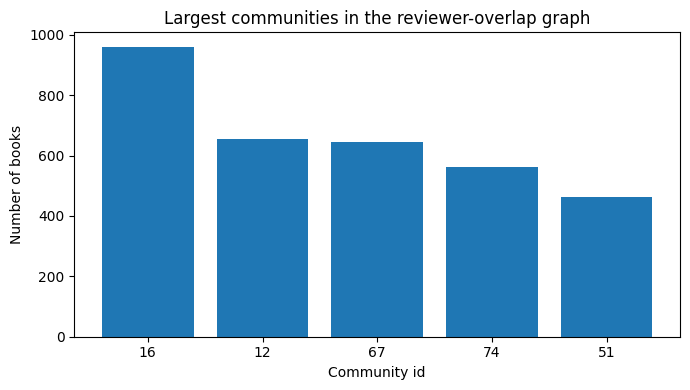

In [ ]:
from networkx.algorithms.community import louvain_communities

communities = louvain_communities(G_lcc, weight="weight", seed=42)
print("Detected communities:", len(communities))

node_to_comm = {}
for cid, comm in enumerate(communities):
    for n in comm:
        node_to_comm[n] = cid

pr_df["community"] = pr_df["Title_canon"].map(node_to_comm)

comm_summary = (
    pr_df.dropna(subset=["community"])
         .groupby("community")
         .agg(
             n_books=("Title_canon", "size"),
             total_pagerank=("pagerank", "sum"),
             top_genre=("category_final",
                        lambda x: x.value_counts().idxmax() if len(x.dropna()) else "Unknown")
         )
         .sort_values("n_books", ascending=False)
)

print("\nTop 10 communities by size:")
print(comm_summary.head(10))

top_comm = comm_summary.head(5)

plt.figure(figsize=(7,4))
plt.bar(top_comm.index.astype(str), top_comm["n_books"])
plt.xlabel("Community id")
plt.ylabel("Number of books")
plt.title("Largest communities in the reviewer-overlap graph")
plt.tight_layout()
plt.show()


The printout of the top-10 communities by size, together with the bar
chart of `n_books` for the five largest communities, shows that:

- the largest clusters contain several hundred books each,
- most of the biggest communities are dominated by `['Fiction']`,
  while others correspond to more specific areas such as
  `['Business & Economics']` or `['History']`.

This confirms that the reviewer-overlap graph is not random: books tend
to cluster into genre-coherent communities, and PageRank mass is
concentrated in a few large, thematically meaningful groups.

### 13. Temporal PageRank

Temporal PageRank extends the baseline PageRank computation by giving **more weight to recent reviews**.  
This allows the ranking to respond to *current* user activity rather than treating all reviews as equally informative.

The key idea:

> Books with **recent review activity** should receive more teleportation mass, while books with only old reviews should contribute less to current influence.

This is done through **personalised PageRank** using a recency-weighted teleportation vector.

#### 13.1 Recency scores and temporal teleportation vector

The canonical interaction table `df_core` contains UNIX timestamps (`review/time`). These are converted to dates and transformed into **review ages** relative to the most recent review.

Recency decay is modelled with an exponential kernel:
$$
w = e^{-\lambda \cdot \text{age (years)}}
$$ with $$(\lambda = 0.7)$$.  
Thus, reviews older than ~5–7 years receive much smaller weights, while recent reviews obtain much larger ones.

For each book:

- review-level recency weights are averaged → `title_recency[t]`,  
- the vector is normalised → becomes the **personalization vector** for PageRank.

This modifies the PageRank behaviour:

- **α = 0.85** — probability of following edges weighted by shared reviewers,  
- **1 − α = 0.15** — teleportation step **biased by recency** instead of uniform jumping.

The output `pagerank_temporal` provides a **recency-aware influence measure**.

Rank shift is defined as:

$$
\text{shift}_{\text{temp vs base}} = \text{rank}_{\text{pr}} - \text{rank}_{\text{temp}}
$$


where positive values indicate a book that becomes *more* central under temporal weighting.


In [ ]:
df_time = df_core[["Title_canon", "review/time"]].copy()

try:
    df_time["review_date"] = pd.to_datetime(df_time["review/time"], unit="s", errors="coerce")
except TypeError:
    df_time["review_date"] = pd.to_datetime(df_time["review/time"], errors="coerce")

df_time = df_time.dropna(subset=["review_date"])

max_date = df_time["review_date"].max()
age_days = (max_date - df_time["review_date"]).dt.days
age_years = age_days / 365.25

lambda_decay = 0.7
df_time["recency_weight"] = np.exp(-lambda_decay * age_years)

title_recency = df_time.groupby("Title_canon")["recency_weight"].mean()
print("Titles with recency scores:", title_recency.shape[0])

teleport = {}
total_mass = 0.0
for n in G_lcc.nodes():
    w = float(title_recency.get(n, 0.0))
    teleport[n] = w
    total_mass += w

if total_mass == 0.0:
    raise ValueError("All temporal weights are zero – check review/time parsing.")

teleport = {n: w / total_mass for n, w in teleport.items()}

pagerank_temp = nx.pagerank(
    G_lcc,
    alpha=0.85,
    weight="weight",
    personalization=teleport
)

pr_df["pagerank_temporal"] = pr_df["Title_canon"].map(pagerank_temp)
pr_df["rank_temp"] = (
    pr_df["pagerank_temporal"]
      .rank(ascending=False, method="min")
      .astype("Int64")
)

mask_temp = pr_df["rank_temp"].notna()
pr_df.loc[mask_temp, "shift_temp_vs_base"] = (
    pr_df.loc[mask_temp, "rank_pr"] - pr_df.loc[mask_temp, "rank_temp"]
)

print("Non-null temporal PageRank:", pr_df["pagerank_temporal"].notna().sum())


Titles with recency scores: 16160
Non-null temporal PageRank: 8687


In this run:

* recency scores are available for **16 160** canonical titles;
* temporal PageRank is non-null for **8 687** books, matching the LCC.

This confirms that temporal PageRank is defined on the same structural core as the
baseline ranking, but now biased towards books with recent review activity.

#### 13.2 Rank shifts: recent hits vs classics

After computing temporal PageRank using a recency-weighted personalization vector, the analysis examines how book rankings change relative to the baseline PageRank.

For clarity, the focus is placed on the top-20 books ranked by baseline PageRank, tracking how their positions shift once temporal weighting is introduced.

Each line in the figure connects:

* the baseline PageRank rank, and

* the corresponding temporal PageRank rank.

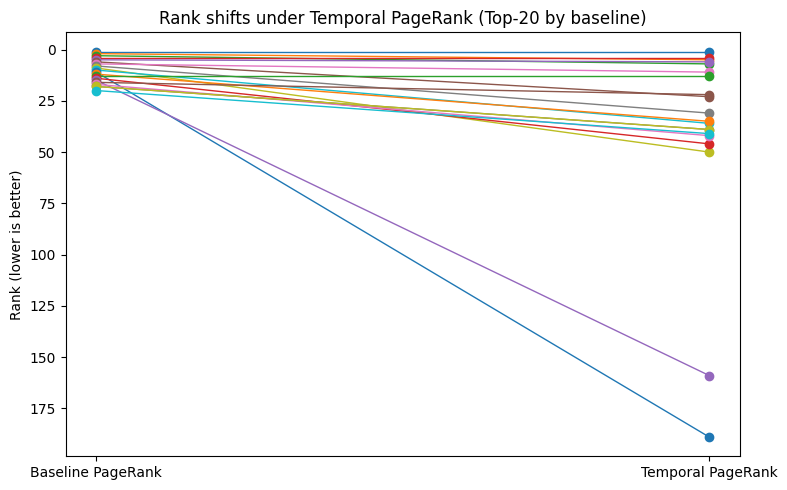

In [ ]:
# Rank-shift visualization (baseline → temporal)
N = 20
topN = (
    pr_df[mask_temp]
    .sort_values("rank_pr")
    .head(N)
    .copy()
)

plt.figure(figsize=(8, 5))

for _, row in topN.iterrows():
    plt.plot(
        [0, 1],
        [row["rank_pr"], row["rank_temp"]],
        marker="o",
        linewidth=1
    )

plt.xticks([0, 1], ["Baseline PageRank", "Temporal PageRank"])
plt.ylabel("Rank (lower is better)")
plt.gca().invert_yaxis()
plt.title("Rank shifts under Temporal PageRank (Top-20 by baseline)")
plt.tight_layout()
plt.show()


* Upward movement (better rank under temporal PageRank) indicates books that benefit from recent review activity (recent hits).

* Downward movement indicates books whose influence is primarily driven by older reviews (structural classics).

This visualization highlights how temporal PageRank distinguishes current momentum from long-term structural importance, which is not visible in the static ranking alone.

### 14. PageRank subgraph visualisation (Top-20 titles)

#### 14.1 Build Top-20 PageRank subgraph

This block restricts the analysis to the **20 books with highest PageRank** in `pr_df`:

* `top20_titles` – list of the 20 titles with largest `pagerank`;
* `G_top20` – induced subgraph of `G_lcc` on those 20 nodes;
* `G_core20` – largest connected component inside `G_top20`.

Working on `G_core20` avoids drawing isolated nodes: the visualisation focuses on the **main local cluster** formed by the top-20 books in the reviewer-overlap graph.

In [ ]:
top20_titles = (
    pr_df.sort_values("pagerank", ascending=False)
         .head(20)["Title_canon"]
         .tolist()
)

# Induced subgraph on G_lcc (only top-20 nodes).
G_top20 = G_lcc.subgraph(top20_titles).copy()

# Keep only the largest connected component inside top-20.
if G_top20.number_of_edges() > 0:
    core_nodes = max(nx.connected_components(G_top20), key=len)
    G_core20 = G_top20.subgraph(core_nodes).copy()
else:
    G_core20 = G_top20


#### 14.2 Draw Top-20 PageRank core

The subgraph `G_core20` is rendered with a force-directed layout:

* node size ∝ normalised PageRank within `G_core20` (`norm_pr`);
* node colour ∝ the same normalised PageRank
  (colourbar shows **relative influence** inside the top-20 set);
* edge width ∝ `weight` (number of shared reviewers).

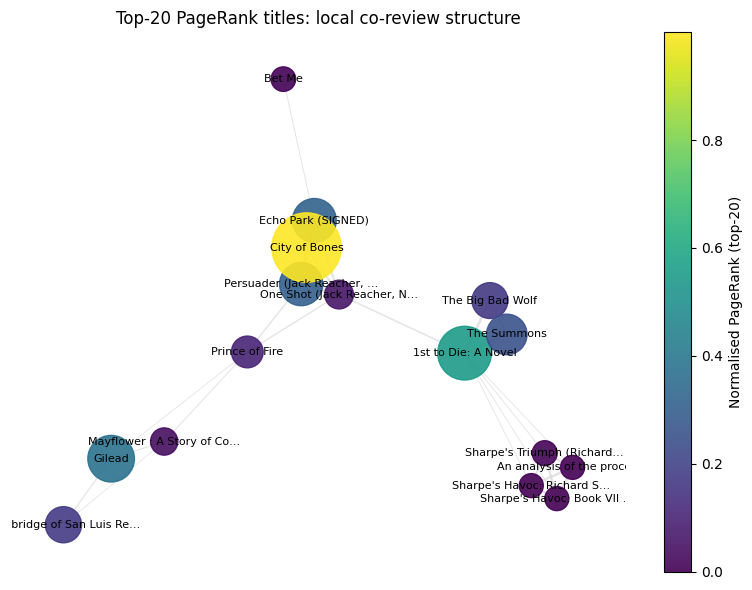

In [ ]:
if G_core20.number_of_nodes() > 0:
    # Normalise PageRank within this subgraph for size/colour.
    pr_top20 = pr_df.set_index("Title_canon").loc[list(G_core20.nodes()), "pagerank"]
    pr_min, pr_max = pr_top20.min(), pr_top20.max()
    norm_pr = {
        t: (pr_top20[t] - pr_min) / (pr_max - pr_min + 1e-12)
        for t in G_core20.nodes()
    }

    pos = nx.spring_layout(G_core20, k=0.8, seed=42)

    node_sizes = [300 + 2200 * norm_pr[n] for n in G_core20.nodes()]
    node_colors = [norm_pr[n] for n in G_core20.nodes()]

    edges = list(G_core20.edges(data=True))
    edge_weights = [d["weight"] for _, _, d in edges]
    max_w = max(edge_weights) if edge_weights else 1
    edge_widths = [0.5 + 2.5 * (w / max_w) for w in edge_weights]

    plt.figure(figsize=(8, 6))

    nodes = nx.draw_networkx_nodes(
        G_core20, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap="viridis",
        alpha=0.9,
    )
    nx.draw_networkx_edges(
        G_core20, pos,
        width=edge_widths,
        edge_color="lightgray",
        alpha=0.6,
    )

    # Shorten long labels for readability.
    labels = {
        n: (n[:25] + "…") if len(n) > 25 else n
        for n in G_core20.nodes()
    }
    nx.draw_networkx_labels(G_core20, pos, labels=labels, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Normalised PageRank (top-20)")

    plt.title("Top-20 PageRank titles: local co-review structure")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Top-20 PageRank titles have no edges between them in the LCC.")


Node colour and size both reflect normalised PageRank  (yellow/large = highest influence; purple/small = lowest).  

* **High-PageRank hubs** (large, bright nodes such as *City of Bones* and *1st to Die*) act as central aggregators in the co-review network, receiving many weighted paths.
* Surrounding them is a **ring of medium-rank nodes** that function as secondary authorities: they connect to the hubs but do not strongly interconnect with each other.
* A **local tightly connected cluster** (e.g., the Sharpe titles) forms a small **community / local authority group**, with strong internal reinforcement but weaker connections to the global hub.
* Several **peripheral nodes** (small, dark nodes) have low PageRank and contribute little to global influence; they rely on a few weak links to the main structure.

Overall, the plot highlights how influence concentrates around a few hub titles, while most books play peripheral or community-specific roles.

## Final Summary — Link Analysis of the Amazon Books Co-Review Graph

Using the Amazon Books Reviews dataset, the co-review network reveals several
consistent patterns about how readers navigate the catalogue.

**1. PageRank identifies structurally central titles, not necessarily the most popular ones.**  
PageRank and review count correlate only weakly: many books with modest popularity
become influential because they sit at intersections of different reader groups.
These titles act as *connectors* in the catalogue, driving traffic between genres.

**2. Degree, closeness and betweenness highlight different dimensions of influence.**  
High-degree books attract broad attention, while high-closeness titles are positioned
to reach the rest of the graph quickly. Betweenness isolates “bridge” books that link
otherwise separate reading niches. These measures confirm that influence on Amazon is
multi-dimensional and cannot be reduced to volume of reviews alone.

**3. The reviewer-overlap graph exhibits clear community structure.**  
Louvain clustering finds large, coherent genre communities (e.g. Fiction clusters,
Business & Economics, History). PageRank mass is unevenly distributed across them:
broad-appeal fiction clusters accumulate the largest share, while specialised
communities remain internal but cohesive. This reflects how readers group around
stable genre ecosystems.

**4. Temporal PageRank captures short-term momentum.**  
When recent reviews are weighted more heavily, a subset of titles moves sharply up
the ranking. These books show strong *current* engagement even if historically
less central. Conversely, long-standing classics lose rank when time is considered:
their influence relies on older review activity. This separation between *timeless*
and *trending* titles is not visible in standard PageRank.

**5. The top-20 subgraph confirms a hub-and-periphery structure.**  
Within the most influential titles, a few dominant hubs anchor the network, while
smaller clusters form niche authority groups. Peripheral books enter the top-20 only
through strong ties to a hub, not through broad connectivity. Visual inspection
matches the quantitative patterns seen in degree and PageRank.

**Overall takeaway:**  
Link analysis provides a richer view of catalogue influence than ratings or
popularity alone. It exposes how books function within reader ecosystems, identifies
bridges between genres, separates long-term central titles from short-term hits, and
reveals how a relatively small portion of books shapes global navigation behaviour
on Amazon’s platform.
